# LatamXIX Overveiw

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

## Surface Forms

In [2]:
with open("./data/surfaceForms.json", encoding='utf-8') as f:
    surfaceForms = json.load(f)
with open("./data/surfaceFormsNonAccents.json", encoding='utf-8') as f:
    surfaceFormsNonAccents = json.load(f)

i = 0
for k,v in surfaceFormsNonAccents.items():
    print(f"The word '{k}' can be find as '{list(v.keys())[0]}'")
    if (i := i+1) > 10: break

The word 'y' can be find as 'i'
The word 'suscripción' can be find as 'suscricion'
The word 'muy' can be find as 'mui'
The word 'hay' can be find as 'hai'
The word 'suscripciones' can be find as 'suscriciones'
The word 'hoy' can be find as 'hoi'
The word 'general' can be find as 'jeneral'
The word 'jefe' can be find as 'gefe'
The word 'suscriptores' can be find as 'suscritores'
The word 'septiembre' can be find as 'setiembre'
The word 'extranjero' can be find as 'extrangero'


In [3]:
print(f"Surface Forms: {len(surfaceForms)}")
print(f"Non-Accent Surface Forms: {len(surfaceFormsNonAccents)}")

Surface Forms: 37492
Non-Accent Surface Forms: 7466


## Dataset

In [4]:
# read the parquet file
cleaneddf = pd.read_parquet("./data/cleaned-latam-xix.parquet")
df = pd.read_parquet("./data/corrected-latam-xix.parquet")
df.sample(10)

,newspaper_id,text_id,title,year,city,text
21231,PD1522,558a33207d1ed64f16908d4a-page_0-0,La linterna,1877,Ciudad de México,CONDICIONES del di Fate periodico se publicart...
61696,PD810,Octubre 1892-page_3-0,El diario de Cundinamarca,1869-1893,Bogotá,"mouOTRO, primero E Ya Rontia a en capalda las ..."
6483,PD1350,558a340d7d1ed64f169fe7a4-page_0-1,El boquiflojo,1869-1871,Ciudad de México,"cia. El Monitor alborozato, dice enter false; ..."
39646,PD1757,MC0057259-page_51-1,El taller ilustrado,1885-1889,"Santiago, Chile","SUMARIO, - Nuestra mision .- Nuestro grabado, ..."
48209,PD1809,1 El Correo del Domingo_ Agosto 1864 - julio 1...,El correo del domingo,1864,"Buenos Aires, Argentina","SUMARIO-La Semana-Roslnn Mariotti, per 0. Z. -..."
57067,PD697,p17054coll26_310-page_3-1,Papel Periodico ilustrado,1881-1888,Cali,Otra de las obras contratadas por FRAY SERAFÍN...
47387,PD1789,la-cabrionera-1874-11-22-page_1-2,La cabrionera,1871-1890,"Rosario, Argentina",Se encuentra en esta ciudad un individu Habien...
45937,PD1788,la-bomba-1894-10-14-page_5-2,La bomba,1894-1895,"Rosario, Argentina",PERMANENTES TCEHIP Hacemos saber a nuestros ab...
32526,PD1695,558a33ec7d1ed64f169d6aa1-page_0-0,Hijo de Ahuizote,1897-1899,Ciudad de México,TAMBORAZO AS@SEMANARIO.OK CENA EN PALACIO. No ...
32322,PD1692,558a32f07d1ed64f168d4f4a-page_0-0,Fregoli,1897-1899,Ciudad de México,ra atender a particulares asuntos que reclaman...


See the corections made to a random text in the dataset. Take into account that surface form were extracted BUT NOT replaced in the dataset.

In [5]:
rd_idx = random.randint(0, len(cleaneddf) - 1)

print(cleaneddf.loc[rd_idx, "text"])
print(df.loc[rd_idx, "text"])

Melodias del Rasca-Tripas. A PAPA GRANDE. Volvió tu protector, volvio tu amigo, Aquel que te hizo grande y te dio juego, Il quo te lizo brincar, de simple lego A guardian, y te dio su grato abrigo. Vino ya, y viene a verselas contigo, Porque ya ingrato y de soberbia ciego, I.e estas dando cabrito por borrego, De lo cual es Trevino fiel testigo. . Tu pretenderas darle el mismo pago Que a los suyos les did cuando le plug. Al destino brindarle con su halago. Pero el ya to vid cara de verdugo, Y' antos bara contigo algun estrag Que dejarse burlar como un tarugo EL FAVORITO. Por fin ya el General Diaz, a quien pudieramos la- diputadossalientes, en el callejon do la Soledad, Los Capital. mar el Proconsul de Oriente, se encuentra en esta entrantes, on In calle del Consuelo ,-- El Dr. Pernin#Los pescadores y cazadores se apresuraron a reei- Baratillo, El Ministerio de Relaciones, en la callo' bir con una ovagion al Presidente del Club; los pri- Verde, - La Secretaría de Hacienda, en la tocinet

### Information

First, train a new tokenizer on the final, corrected dataset.

In [6]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
tokenizer.save_pretrained("./data/tokenizer")

Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (781 > 512). Running this sequence through the model will result in indexing errors


BEFORE: ['46', '##1', ',', '60', 'Y', '[UNK]', 'de', 'arrepent', '##irse', 'de', 'tal', 'ase', '##r', '##cion', ',', 'I', 'se', 'les', 'bar', '##re']
AFTER: ['46', '##1', ',', '60', 'Y', 'debi', '##ć', 'de', 'arrepentirse', 'de', 'tal', 'aser', '##cion', ',', 'I', 'se', 'les', 'barre', 'una', 'perten']


('./data/tokenizer\\tokenizer_config.json',
 './data/tokenizer\\special_tokens_map.json',
 './data/tokenizer\\vocab.txt',
 './data/tokenizer\\added_tokens.json',
 './data/tokenizer\\tokenizer.json')

In [8]:
# find the number of tokens in the whole df

total_tokens = df['text'].apply(lambda x: len(tokenizer.tokenize(x))).sum()
total_words = df['text'].apply(lambda x: len(x.split())).sum()

print(f"LatamXIX dataset has:\n\ttokens: {total_tokens:,}\n\twords: {total_words:,}\n\ttexts: {len(df):,}")

LatamXIX dataset has:
	tokens: 28,677,109
	words: 22,002,110
	texts: 64,077


In [9]:
unique_count = df["newspaper_id"].nunique()
print(f"{unique_count} newspapers in the dataset")

197 newspapers in the dataset


In [10]:
df['year_low'] = df['year'].str.split('-').str[0]
df['year_low'] = df['year_low'].astype(int)
df['year_high'] = df['year'].apply(lambda x: x.split('-')[1] if len(x.split('-')) == 2 else x.split('-')[0])
df['year_high'] = df['year_high'].astype(int)

print(f"\nYears: {df['year_low'].min()} - {df['year_low'].max()}")


Years: 1806 - 1899


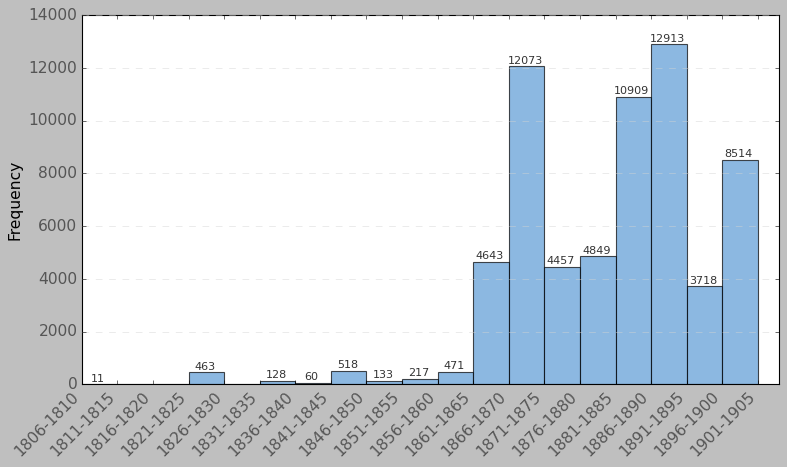

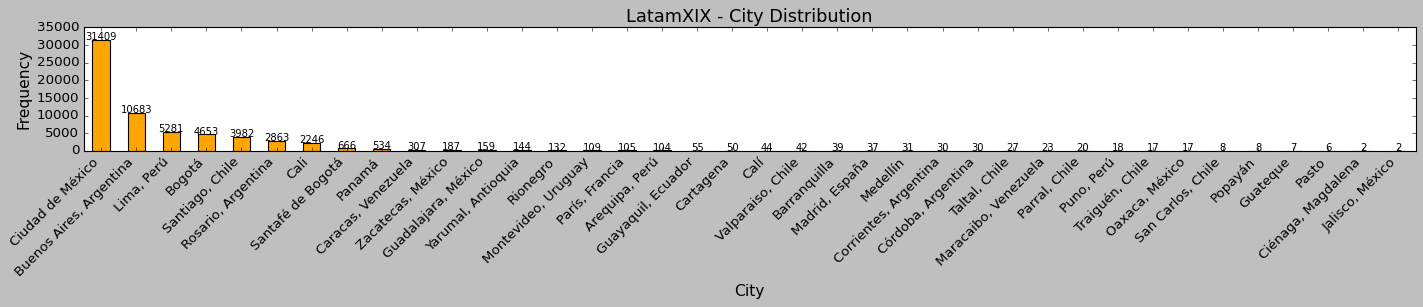

In [11]:
plt.style.use('classic')

# Histogram by Decade
min_year = df['year_low'].min()
max_year = df['year_low'].max()
bin_width = 5

# Create bins ensuring the last bin captures the correct decade
bins = np.arange(min_year, max_year + bin_width, bin_width)  # Inclusive of max_year

plt.figure(figsize=(10, 6))  # Increased figure size for better clarity

# Calculate counts for the histogram
counts, _ = np.histogram(df['year_low'], bins=bins)

# Only include bins with counts greater than 0 for plotting
plt.hist(bins[:-1], bins=bins, weights=counts, edgecolor='black', align='mid', color='#5B9BD5', alpha=0.7)

# Set y-ticks and customize
plt.yticks(fontsize=14, color='#555555')
plt.xticks(np.arange(min_year, max_year + bin_width, bin_width),
           [f'{int(year)}-{int(year + bin_width - 1)}' for year in np.arange(min_year, max_year + bin_width, bin_width)],
           rotation=45, ha='right', fontsize=14, color='#555555')  # Adjusted x-tick font size and color

# Add gridlines for better readability with lighter dashed lines
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.8)
plt.ylabel('Frequency', fontsize=14)

# Annotate bars with counts only where counts are greater than 0
for i, count in enumerate(counts):
    if count > 0:  # Only annotate bars that have counts
        plt.text(bins[i] + 2.3, count + 100, str(count), ha='center', fontsize=10, color='#333333')

# Adjust xlim to remove extra white space on the right
plt.xlim(min_year, max_year + bin_width)

# Remove title and x-label
plt.title('')  # Ensuring title is blank
plt.xlabel('')  # Ensuring x-label is blank

plt.tight_layout()
plt.savefig('./imgs/latamxix_years_histogram.png', dpi=300)
plt.show()

# Histogram by City

plt.figure(figsize=(18, 4))
df['city'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('LatamXIX - City Distribution', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(df['city'].value_counts()):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_city_histogram.png', dpi=300)
plt.show()